# Data Science project - OD Travel time Predictor
Students : Alix MEULOT, Anaëlle Marty, Ghislain MUTABAZI, Nathan DAMBREVILLE

## <u> **I/ Data preprocessing** </u>
###  <u> **0 - Imports** </u>
#### a/ Libraries import

In [39]:
import glob
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

after = """ 
import seaborn as sns

from sklearn.metrics import pairwise_distances, r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV
from sklearn import tree
"""
print("✅ Libraries successfully imported")

✅ Libraries successfully imported


#### b/ `read_whole_pandas_df` function import

In [2]:
alt_path = '/home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv'

def read_whole_pandas_df(path, alternative_path=alt_path, sep = ",", enc = None, columns = None, parse_dates=None, format=None, alternative_dataset = False):
    if alternative_dataset:
        all_files = [alternative_path]
    else:
        all_files = glob.glob(path)
    li = []
    for filename in all_files:
        print("Reading file {}".format(filename))
        df = pd.read_csv(filename, encoding = enc, sep=sep, names = columns, header=0)
        li.append(df)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

print(f"✅ read_whole_pandas_df function successfully defined, with alternative_path set as:\n{alt_path}")

✅ read_whole_pandas_df function successfully defined, with alternative_path set as:
/home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv


#### c/ Data import

In [64]:
BASE_PATH = r"/home/ghislain/data_relou/"  #replace with base path to velo's data
LYON_PATH = BASE_PATH + r"VELO-LYON/Trajets VELOV */*.csv"
LYON_LOCATIONS = BASE_PATH + r"VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json"
LYON_IRIS = BASE_PATH + r"iris_lyon.shp"
LYON_CENTER = (45.764043, 4.835659)
df_lyon = read_whole_pandas_df(LYON_PATH, alternative_path=alt_path, sep = ";", enc = "ISO-8859-1", 
                               columns = ["id_exit_station", "exit_station", "date_exit", "id_return_station", "return_station", "date_return"], alternative_dataset=True)
print(f"✅ All datasets were successfully imported")

df_lyon["date_exit"] = pd.to_datetime(df_lyon['date_exit'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
df_lyon["date_return"] = pd.to_datetime(df_lyon['date_return'], format="%Y/%m/%d %H:%M:%S").dt.tz_localize("Europe/Paris", ambiguous="NaT")
print(f"✅ The columns |date_exit| and |date_return| were successfully converted to datetime.")
print(" Size of the dataframe:", df_lyon.shape)
df_lyon.head()

Reading file /home/ghislain/data_relou/VELO-LYON/Trajets VELOV 2019/VELOV_TRAJETS_2019_T2.csv
✅ All datasets were successfully imported
✅ The columns |date_exit| and |date_return| were successfully converted to datetime.
 Size of the dataframe: (2142472, 6)


,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00


###  <u> **1 - Adding intermediate columns** </u>
#### a/ Floored datetime column

In [ ]:
df_lyon['datetime_1h'] = df_lyon['date_exit'].dt.floor("1h")
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0


#### b/ `day`, `month`, and `travel_time` columns
**NB:** The travel time is computed in minutes.

In [6]:
df_lyon['day'] = df_lyon.date_exit.dt.day_of_week
df_lyon['month'] = df_lyon.date_exit.dt.month
df_lyon['travel_time'] =  (df_lyon.date_return-df_lyon.date_exit).dt.total_seconds()/60
df_lyon.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,2019-04-01 00:00:00+02:00,0,4,28.0
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2019-04-01 00:00:00+02:00,0,4,7.0
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,2019-04-01 00:00:00+02:00,0,4,14.0
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,2019-04-01 00:00:00+02:00,0,4,4.0


###  <u> **2 - Adding the `distance` column** </u>

In [7]:
gdf_stations = gpd.read_file(LYON_LOCATIONS)
gdf_stations.to_crs('2154', inplace=True)

coords = np.array([[geom.x, geom.y] for geom in gdf_stations.geometry.centroid])
dist_matrix = pairwise_distances(coords, metric="euclidean")
df_dist = pd.DataFrame(dist_matrix, index=gdf_stations['idstation'], columns=gdf_stations['idstation'])
display(df_dist.head())

df_lyon = df_lyon[df_lyon.id_exit_station.isin(df_dist.index) & df_lyon.id_return_station.isin(df_dist.index)].copy()
row_idx = df_dist.index.get_indexer(df_lyon.id_exit_station)
col_idx = df_dist.columns.get_indexer(df_lyon.id_return_station)
df_lyon["distance"] = df_dist.to_numpy()[row_idx, col_idx]
df_lyon.head()

NameError: name 'pairwise_distances' is not defined

###  <u> **3 - Filtering** </u>

In [8]:
df_lyon = df_lyon[df_lyon.id_exit_station != df_lyon.id_return_station]
df_lyon = df_lyon[df_lyon.travel_time<30]
df_lyon = df_lyon[df_lyon.travel_time>0]
df_lyon.sample(10)

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,datetime_1h,day,month,travel_time
691861,3016,3016 - LIBERTÉ / PART-DIEU,2019-04-29 19:59:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-29 20:08:00+02:00,2019-04-29 19:00:00+02:00,0,4,9.0
2094779,8035,8035 - SANS SOUCI,2019-06-28 06:39:00+02:00,3016.0,3016 - LIBERTÉ / PART-DIEU,2019-06-28 06:50:00+02:00,2019-06-28 06:00:00+02:00,4,6,11.0
963999,6005,6005 - PLACE EDGAR QUINET,2019-05-10 17:04:00+02:00,8057.0,8057 - VIENNE / MONTAGNY,2019-05-10 17:24:00+02:00,2019-05-10 17:00:00+02:00,4,5,20.0
1256050,10041,10041 - KIMMERLING,2019-05-22 17:50:00+02:00,7009.0,7009 - JEAN JAURÈS,2019-05-22 18:18:00+02:00,2019-05-22 17:00:00+02:00,2,5,28.0
151517,7001,7001 - PLACE GABRIEL PÉRI,2019-04-06 16:25:00+02:00,7056.0,7056 - PLACE RASPAIL,2019-04-06 16:26:00+02:00,2019-04-06 16:00:00+02:00,5,4,1.0
1461552,9032,9032 - PLACE DU PORT MOUTON,2019-05-30 02:39:00+02:00,9014.0,9014 - QUAI DU COMMERCE,2019-05-30 02:43:00+02:00,2019-05-30 02:00:00+02:00,3,5,4.0
469967,3097,3097 - AUGAGNEUR / FOSSE AUX OURS,2019-04-18 21:44:00+02:00,7031.0,7031 - JAURÈS / GERLAND,2019-04-18 21:58:00+02:00,2019-04-18 21:00:00+02:00,3,4,14.0
1784858,5004,5004 - SAINT-JEAN,2019-06-13 22:46:00+02:00,8053.0,8053 - LUMIERE / TROUILHET,2019-06-13 23:12:00+02:00,2019-06-13 22:00:00+02:00,3,6,26.0
958773,10121,10121 - PARC DU CENTRE,2019-05-10 13:56:00+02:00,10002.0,10002 - INSA,2019-05-10 14:01:00+02:00,2019-05-10 13:00:00+02:00,4,5,5.0
1459026,10046,10046 - CHARMETTES/ZOLA,2019-05-29 23:35:00+02:00,1032.0,1032 - PIZAY,2019-05-29 23:46:00+02:00,2019-05-29 23:00:00+02:00,2,5,11.0


## <u> **II/ Regression modelling** </u>

###  <u> **1 - Model 0 // Simple linear regression** </u>
#### a/ Model definition

In [28]:
# STEP 1 - GIVE IT A NAME

y = df_lyon['travel_time']
X = df_lyon[['distance']]

# STEP 2 - GIVE IT A NAME

split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# STEP 3 - GIVE IT A NAME AND COMMENT ON EACH LINE

model = LinearRegression() 
model.fit(X_train, y_train) 
y_pred = model.predict(X_test) 

print(model.intercept_, model.coef_, )

# STEP 4 - GIVE IT A NAME
s_validation = pd.Series({
    'R²': r2_score(y_test, y_pred),
    'MSE': mean_squared_error(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
})
s_validation

2.741699833987841 [0.00490217]


R²      0.612275
MSE    14.436226
MAE     2.630258
dtype: float64

In [29]:
# Plotting a scatter graph of the travels' distance and duration (i.e. travel time) and the line of our regression model
## /!\ Code below runs in 10min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_lyon, alpha=0.1, label='Data points')
#sns.lineplot(x=X_test['distance'], y=y_pred, color='red', label='Regression line')
#plt.title('Travel Time vs Distance (with Regression Line)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Future functions

In [30]:
def my_train_test_split(X, Y, rate = 0.8):
    split_idx = int(len(X) * rate)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = Y.iloc[:split_idx], Y.iloc[split_idx:]
    return X_train, X_test, y_train, y_test

def build_coeffs_df(model):
    df_coeff = pd.DataFrame({
        'Coefficient': model.coef_
    }, index = X.columns)
    df_coeff.sort_values(by='Coefficient', ascending=False, inplace=True) 
    df_coeff = df_coeff.T
    df_coeff['intercept'] = model.intercept_
    df_coeff = df_coeff.T

    return df_coeff

def build_validation_serie(y_test, y_pred):
    s_validation = pd.Series({
        'R²': r2_score(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'MAE': mean_absolute_error(y_test, y_pred),
    })
    return s_validation

###  <u> **1 - Model 1 // Multiple linear regression** </u>
#### a/ Adding the day of the week parameter

In [31]:
# Extracting a subset of our original dataframe with only the columns at use
df_model1 = df_lyon[['distance', 'travel_time', 'datetime_1h', 'day', 'month']].copy()
df_model1.sample(5)

,distance,travel_time,datetime_1h,day,month
701206,545.588859,3.0,2019-04-30 09:00:00+02:00,1,4
1865037,1298.510255,7.0,2019-06-18 08:00:00+02:00,1,6
958742,994.196704,9.0,2019-05-10 13:00:00+02:00,4,5
1430649,1106.137653,7.0,2019-05-28 23:00:00+02:00,1,5
1103417,1234.408775,7.0,2019-05-16 13:00:00+02:00,3,5


In [32]:
# Creating a dataframe with the columns distance, travel_time, and dummies representing the day of the week
df_model1_dummies = pd.get_dummies(df_model1, columns=['day'], drop_first=True, dtype="int")
df_model1_dummies.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6
1853779,766.025237,4.0,2019-06-17 18:00:00+02:00,6,0,0,0,0,0,0
170259,1584.393560,9.0,2019-04-07 14:00:00+02:00,4,0,0,0,0,0,1
687695,2422.922403,18.0,2019-04-29 18:00:00+02:00,4,0,0,0,0,0,0
1300689,1119.703494,13.0,2019-05-24 04:00:00+02:00,5,0,0,0,1,0,0
1661353,1178.341104,7.0,2019-06-07 08:00:00+02:00,6,0,0,0,1,0,0


,Coefficient
day_5,1.027371
day_6,0.886977
day_2,0.285906
day_4,0.283732
day_3,0.112139
day_1,0.056494
distance,0.004896
intercept,2.435412


R²      0.615426
MSE    14.318934
MAE     2.623344
dtype: float64

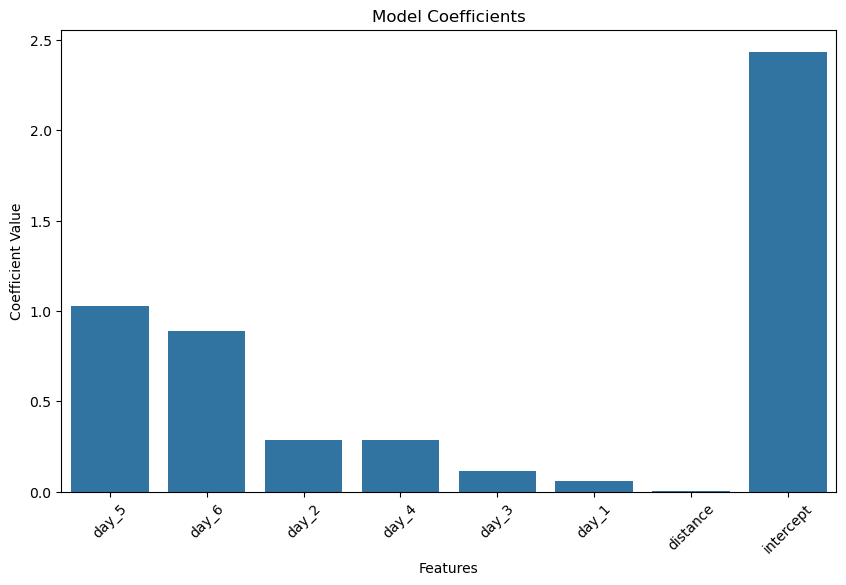

In [33]:
# Creating our multi-linear regression model, predicting the travel time based on the distance and which day of the week it is
## Splitting our data using my_train_test_split function
y = df_model1_dummies['travel_time']
X = df_model1_dummies.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our model 1: model1_day
model1_day = LinearRegression()
model1_day.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1 = model1_day.predict(X_test)
s_model1_validation = build_validation_serie(y_test, y_pred_model1)
display(s_model1_validation)

## Plotting a bar plot of the model's coefficients
plt.figure(figsize=(10, 6))
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index())
plt.title('Model Coefficients')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

## Plotting a scatter graph of the travels' distance and duration (i.e. travel time)
## and the lines of our multi-linear regression model, with different colors for each day of the week
## /!\ Code below runs in 15min+

#plt.figure(figsize=(10, 6))
#sns.scatterplot(x='distance', y='travel_time', data=df_model1_dummies, alpha=0.01, label='Data points')
#for day in range(1, 7):
#    day_columns = [col for col in X_test.columns if col.startswith('day_')]
#    day_dummies = np.zeros((len(X_test), len(day_columns)))
#    if day - 1 < len(day_columns):
#        day_dummies[:, day - 1] = 1
#    X_temp = X_test.copy()
#    X_temp[day_columns] = day_dummies
#    y_pred_day = model1_day.predict(X_temp)
#    sns.lineplot(x=X_test['distance'], y=y_pred_day, label=f'Day {day}')
#plt.title('Travel Time vs Distance (with Regression Lines for Each Day)')
#plt.xlabel('Distance (meters)')
#plt.ylabel('Travel Time (minutes)')
#plt.legend()
#plt.show()

#### b/ Adding the time of day parameter

In [ ]:
# Adding the dummies column indicating which hour of the day it is
df_model1['hour'] = df_model1['datetime_1h'].dt.hour
df_model1_dummies_hour = pd.get_dummies(df_model1, columns=['day', 'hour'], drop_first=True, dtype="int")
df_model1_dummies_hour.sample(5)

,distance,travel_time,datetime_1h,month,day_1,day_2,day_3,day_4,day_5,day_6,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
1265468,900.682137,5.0,2019-05-22 22:00:00+02:00,5,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
337918,1432.448148,8.0,2019-04-13 09:00:00+02:00,4,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
167025,1168.058147,6.0,2019-04-07 11:00:00+02:00,4,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
344092,1575.315469,13.0,2019-04-13 14:00:00+02:00,4,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
383005,1391.455729,9.0,2019-04-15 12:00:00+02:00,4,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


: 

In [ ]:
# Creating our multi-linear regression model, predicting the travel time based on the previous parameters and the hour of the day
## Splitting our data using my_train_test_split function
y = df_model1_dummies_hour['travel_time']
X = df_model1_dummies_hour.drop(columns=['month', 'datetime_1h', 'travel_time'])
X_train, X_test, y_train, y_test = my_train_test_split(X, y)

## Creating our new model 1: model1_day_hour
model1_day_hour = LinearRegression()
model1_day_hour.fit(X_train, y_train)

## Retrieval of its coefficient estimates
df_model1_coeffs = build_coeffs_df(model1_day_hour)
display(df_model1_coeffs)

## Displaying the model 1's validation serie
y_pred_model1_day_hour = model1_day_hour.predict(X_test)
s_model1_day_hour_validation = build_validation_serie(y_test, y_pred_model1_day_hour)
display(s_model1_day_hour_validation)

## Plotting 3 bar plots of the model's coefficients
### Plotting the first bar plot with the intercept, the distance and the days of the week
df_days = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('day_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_days.index, y='Coefficient', data=df_days.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Days of the Week')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the second bar plot with the intercept, the distance and the hours of the day
df_hours = df_model1_coeffs[df_model1_coeffs.index.isin(['intercept', 'distance']) | df_model1_coeffs.index.str.startswith('hour_')]
plt.figure(figsize=(10, 6))
sns.barplot(x=df_hours.index, y='Coefficient', data=df_hours.reset_index())
plt.title('Model Coefficients - Intercept, Distance, Hours of the Day')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45)
plt.show()

### Plotting the last bar plot with all the coefficients and setting 2 different colors
### for the intercept and the distance, and setting 2 different gradient for the hours of the day
### and the days of the week
plt.figure(figsize=(12, 8))
colors = []
for idx in df_model1_coeffs.index:
    if idx == 'intercept':
        colors.append('blue')
    elif idx == 'distance':
        colors.append('green')
    elif idx.startswith('day_'):
        colors.append(plt.cm.Oranges(int(idx.split('_')[1]) * 30))
    elif idx.startswith('hour_'):
        colors.append(plt.cm.Greens(int(idx.split('_')[1]) * 10))
    else:
        colors.append('gray')
sns.barplot(x=df_model1_coeffs.index, y='Coefficient', data=df_model1_coeffs.reset_index(), palette=colors)
plt.title('Model Coefficients - Full View')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=90)
plt.show()

###  <u> **2 - Model 2 // Finding clusters affecting þe travel time** </u>

#### a/ Adding cluster columns

In [ ]:
# Loading station coordinates
gdf_stations = gpd.read_file(BASE_PATH + 'VELO-LYON/locations/pvo_patrimoine_voirie.pvostationvelov.json')
gdf_stations.to_crs(epsg=4326, inplace=True)

print("Columns : ",  list(gdf_stations.columns) )
print("Shape of gdf_stations:", gdf_stations.shape)
print("Number of unique stations:", gdf_stations['idstation'].nunique())

columns :  ['idstation', 'nom', 'adresse1', 'adresse2', 'commune', 'numdansarrondissement', 'nbbornettes', 'stationbonus', 'pole', 'ouverte', 'achevement', 'gid', 'code_insee', 'geometry']
Shape of gdf_stations: (431, 14)
Number of unique stations: 431


In [65]:
# Extract longitude (x) and latitude (y) as numeric columns
gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
gdf_stations['latitude'] = gdf_stations.geometry.centroid.y

gdf_useful = gdf_stations[['idstation', 'longitude', 'latitude']]
del gdf_stations

print(gdf_useful.head())

   idstation  longitude   latitude
0       7024   4.840525  45.748520
1      10063   4.885609  45.758392
2      10021   4.889947  45.759718
3       8038   4.867429  45.746716
4       7045   4.824488  45.737741


/tmp/ipykernel_6478/2997423153.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['longitude'] = gdf_stations.geometry.centroid.x
/tmp/ipykernel_6478/2997423153.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_stations['latitude'] = gdf_stations.geometry.centroid.y


Les coordonnées sont directement prises de Google Maps, elles correspondent grossièrement au centre du pôle d'influence considéré. (Il est possible de trouver une méthode plus systématique et/ou logique «transport wise» mais jsp+flemme)

In [67]:
# STEP 1 - Define the coordinates of each cluster center
clusters_centers = {
    'LA_DOUA': (45.783479, 4.875842),
    'TETE_D_OR': (45.778341, 4.853017),
    'LA_PART_DIEU': (45.761882, 4.855204),
    'OLD_TOWN': (45.764043, 4.835659),
    'CONFLUENCE': (45.732634, 4.819839)
}

# STEP 2 - Function to calculate distance between two geographic points
def haversine(lon1, lat1, lon2, lat2):
    R = 6371  # Radius of the Earth in kilometers
    dlon = np.radians(lon2 - lon1)
    dlat = np.radians(lat2 - lat1)
    a = np.sin(dlat / 2) ** 2 + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c * 1000  # Return distance in meters


- Assignement de toutes les stations à un cluster, suivant si elles sont à moins de __tol__ kilomètres. (On suppose que les gens sont prêts à marcher une distance = __tol__ )

In [69]:
tol = 1000  # en mètres
for name, (lat_c, lon_c) in clusters_centers.items():
    distances = haversine(
        gdf_useful['longitude'], gdf_useful['latitude'],
        lon_c, lat_c
    )
    gdf_useful[name] = (distances < tol).astype(int)

# Création d'une colonne indiquant les stations qui n'ont pas été assignées à un cluster
gdf_useful['NO_CLUSTER'] = (gdf_useful[list(clusters_centers.keys())].sum(axis=1) == 0).astype(int)

# Nettoyage
del distances
gdf_useful.head(10)

,idstation,longitude,latitude,LA_DOUA,TETE_D_OR,LA_PART_DIEU,OLD_TOWN,CONFLUENCE,NO_CLUSTER
0,7024,4.840525,45.748520,0,0,0,0,0,1
1,10063,4.885609,45.758392,0,0,0,0,0,1
2,10021,4.889947,45.759718,0,0,0,0,0,1
3,8038,4.867429,45.746716,0,0,0,0,0,1
4,7045,4.824488,45.737741,0,0,0,0,1,0
5,6045,4.857002,45.766367,0,0,1,0,0,0
6,8056,4.856813,45.735795,0,0,0,0,0,1
7,8015,4.874194,45.740326,0,0,0,0,0,1
8,7057,4.835497,45.734725,0,0,0,0,0,1
9,7007,4.827719,45.735674,0,0,0,0,1,0


- Vérifions qu'il y ait un nombre raisonnable de stations par centre d'intérêt

In [71]:
print("Number of stations in")
print("LA_PART_DIEU :", gdf_useful['LA_PART_DIEU'].sum(), ", soit ", round(gdf_useful['LA_PART_DIEU'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")
print("TETE_D_OR :", gdf_useful['TETE_D_OR'].sum(), ", soit ", round(gdf_useful['TETE_D_OR'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")
print("LA_DOUA :", gdf_useful['LA_DOUA'].sum(), ", soit ", round(gdf_useful['LA_DOUA'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")
print("OLD_TOWN :", gdf_useful['OLD_TOWN'].sum(), ", soit ", round(gdf_useful['OLD_TOWN'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")
print("CONFLUENCE :", gdf_useful['CONFLUENCE'].sum(), ", soit ", round(gdf_useful['CONFLUENCE'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

# Nombre de stations non assignées à un cluster
print("NO_CLUSTER :", gdf_useful['NO_CLUSTER'].sum(), ", soit ", round(gdf_useful['NO_CLUSTER'].sum() / gdf_useful.shape[0] * 100, ndigits=2), "%")

Number of stations in
LA_PART_DIEU : 42 , soit  9.74 %
TETE_D_OR : 22 , soit  5.1 %
LA_DOUA : 14 , soit  3.25 %
OLD_TOWN : 50 , soit  11.6 %
CONFLUENCE : 11 , soit  2.55 %
NO_CLUSTER : 299 , soit  69.37 %


- Définition des centroïdes pour chaque centre d'intérêt (dictionnaire `clusters_centroids` utile pour le dénivelé)

In [56]:
clusters_centroids = {}

# Nombre de chiffres significatifs du calcul des coordonnées des centroïdes
n_ = 3 # +1 !

for cluster in clusters_centers.keys():
    # Filtrer les stations proches du lieu (valeur = 1)
    subset = gdf_useful[gdf_useful[cluster] == 1]

    # Calcul de la moyenne des coordonnées
    mean_lat = subset['latitude'].mean()
    mean_lon = subset['longitude'].mean()

    # Stocker le centroïde arrondi dans le dictionnaire
    clusters_centroids[cluster] = (round(mean_lat, ndigits=n_), round(mean_lon, ndigits=n_))

# Suppression des variables temporaires
del mean_lat, mean_lon, subset, n_

clusters_centroids


{'LA_DOUA': (np.float64(45.78), np.float64(4.876)),
 'TETE_D_OR': (np.float64(45.778), np.float64(4.854)),
 'LA_PART_DIEU': (np.float64(45.761), np.float64(4.855)),
 'OLD_TOWN': (np.float64(45.764), np.float64(4.835)),
 'CONFLUENCE': (np.float64(45.734), np.float64(4.822))}

#### b/ Visual check of þe clusters

/tmp/ipykernel_6478/3101451237.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6478/3101451237.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6478/3101451237.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6478/3101451237.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(
/tmp/ipykernel_6478/3101451237.py:70: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle(


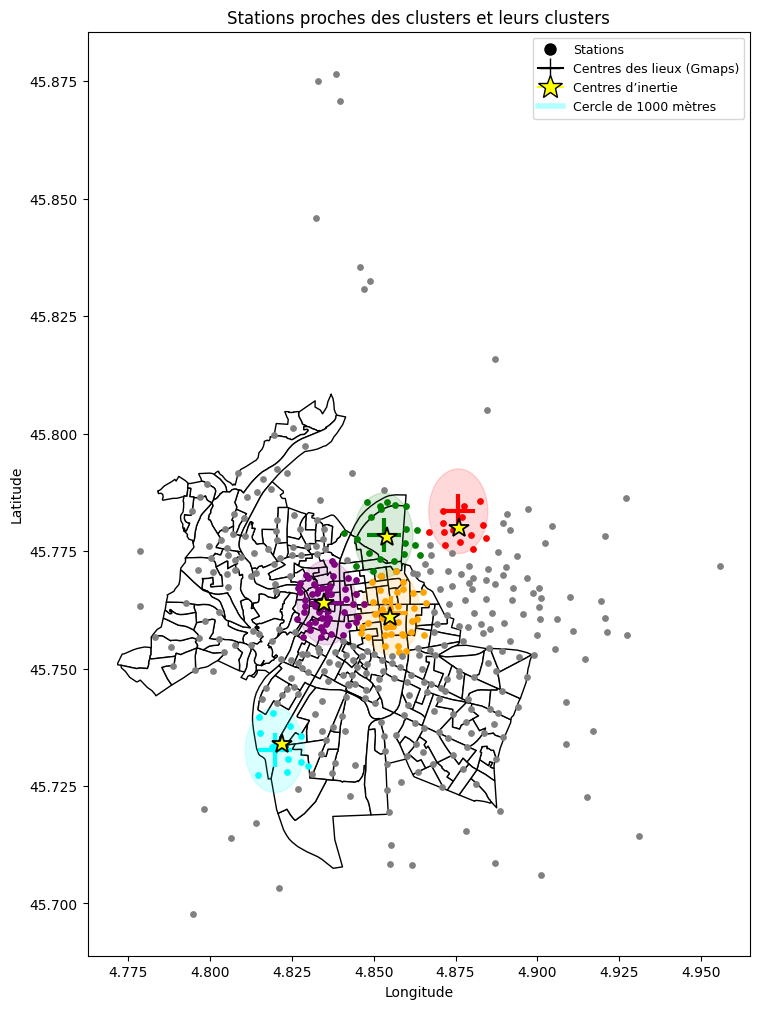

✅ Map with points, centroids, and centers successfully plotted.


In [61]:
# Charger le shapefile
gdf = gpd.read_file(LYON_IRIS)
gdf.to_crs(epsg=4326, inplace=True)

# Convertir df en GeoDataFrame de points
gdf_points = gpd.GeoDataFrame(
    gdf_useful,
    geometry=gpd.points_from_xy(gdf_useful.longitude, gdf_useful.latitude),
    crs="EPSG:4326"  # car mes coordonnées sont en lat/lon
)

# --- Couleurs pour chaque lieu ---
color_map = {
    'LA_DOUA': 'red',
    "TETE_D_OR": 'green',
    'LA_PART_DIEU': 'orange',
    'OLD_TOWN': 'purple',
    'CONFLUENCE': 'cyan'
}

fig, ax = plt.subplots(figsize=(12, 12))

# Fond de carte
gdf.plot(ax=ax, facecolor="white", edgecolor="black")

legend_handles = []  # pour créer une légende propre

for place, (lat_c, lon_c) in clusters_centers.items():

    color0 = color_map[place]

    # -----------------------------
    # 1/6 Stations proches (points)
    # -----------------------------
    pts = gdf_points[gdf_points[place] == 1].plot(
        ax=ax,
        color=color0,
        markersize=15
    )
    
    # -----------------------------
    # 2/6 Centre exact du lieu (+)
    # -----------------------------
    ax.plot(
        lon_c, lat_c,
        marker="+",
        markersize=25,
        color=color0,
        mew=3
    )

    # -----------------------------
    # 3/6 Centre d’inertie (étoile)
    # -----------------------------
    lat_mean, lon_mean = clusters_centroids[place]
    ax.plot(
        lon_mean, lat_mean,
        marker="*",
        markersize=15,
        color="yellow",
        markeredgecolor="black",
        markeredgewidth=1.3
    )

    # -----------------------------
    # 4/6 Cercle (buffer de 1 km)
    # -----------------------------
    # Conversion approx. km → degrés (1° lat ≈ 111 km)
    km_to_deg = 1 / 111  
    circle = plt.Circle(
        (lon_c, lat_c),
        km_to_deg,
        color=color0,
        alpha=0.15,
        edgecolor=color0
    )
    ax.add_patch(circle)

# -----------------------------
# 5/6 Stations en dehors des clusters (points)
# -----------------------------
pts = gdf_points[gdf_points['NO_CLUSTER'] == 1].plot(
    ax=ax,
    color='gray',
    markersize=15
)

# -----------------------------
# 6/6 Éléments pour la légende
# -----------------------------
legend_handles.append(
    plt.Line2D([0], [0], marker='o', color='white', markerfacecolor='black',
                label=f"Stations", markersize=10)
)
legend_handles.append(
    plt.Line2D([0], [0], marker='+', color='black', markersize=15,
                label=f"Centres des lieux (Gmaps)")
)
legend_handles.append(
    plt.Line2D([0], [0], marker='*', color='yellow', markeredgecolor='black',
                markersize=18, label=f"Centres d’inertie")
)
legend_handles.append(
    plt.Line2D([0], [0], color=color0, lw=4, alpha=0.3,
                label=f"Cercle de {tol} mètres")
)
    
# --- Mise en forme finale ---
plt.title(f"Stations proches des clusters et leurs clusters")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend(handles=legend_handles, loc='upper right', fontsize=9)
plt.grid(False)

plt.show()
print("✅ Map with points, centroids, and centers successfully plotted.")

#### c/ Multi Linear regression (en cours) 

In [ ]:
# STEP 3 - Assign clusters to each trip based on return stations
df = df_stations_both.merge(
    gdf_useful[['idstation', 'latitude', 'longitude']],
    left_on='id_return_station',
    right_on='idstation',
    how='left'
).rename(columns={'latitude': 'lat_return', 'longitude': 'lon_return'})

df.head()

,id_exit_station,exit_station,date_exit,id_return_station,return_station,date_return,idstation,lat_return,lon_return
0,8058,8058 - LONGEFER / KRUGER,2019-04-01 00:00:00+02:00,1022.0,1022 - PLACE TOLOZAN,2019-04-01 00:28:00+02:00,1022,45.769601,4.837608
1,10103,10103 - DOUA / RUE DES SPORTS,2019-04-01 00:00:00+02:00,6042.0,6042 - CITÉ INTERNATIONALE / RÉSIDENCE HÔTELIÈRE,2019-04-01 00:07:00+02:00,6042,45.784818,4.856512
2,3003,3003 - PART-DIEU / DERUELLE,2019-04-01 00:00:00+02:00,2016.0,2016 - PLACE REGAUD,2019-04-01 00:07:00+02:00,2016,45.763077,4.834287
3,6043,6043 - CITÉ INTERNATIONALE / CINÉMA,2019-04-01 00:00:00+02:00,3005.0,3005 - SAXE / GAMBETTA,2019-04-01 00:14:00+02:00,3005,45.753786,4.848042
4,7033,7033 - SAINT-LUC / SAINT-JOSEPH,2019-04-01 00:01:00+02:00,7053.0,7053 - JAURÈS / THIBAUDIÈRE,2019-04-01 00:05:00+02:00,7053,45.750345,4.845048


In [ ]:
# Make sure each cluster has at least 10 stations assigned to it
for cluster, (lat, lon) in clusters_centers.items() :
    df[f'is_{cluster}'] = df.apply(
        lambda row: distance_station_point(gdf_useful, row['id_return_station'], lon, lat) < 700, axis=1)

